In [1]:
import pandas as pd
import numpy as np 
import datetime 
from datetime import timedelta
import os 
import polars as pl

import seaborn as sns
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
root = "/kaggle/input/predict-energy-behavior-of-prosumers"

data_cols = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime', 'row_id']
client_cols = ['product_type', 'county', 'eic_count', 'installed_capacity', 'is_business', 'date']
gas_prices_cols = ['forecast_date', 'lowest_price_per_mwh', 'highest_price_per_mwh']
electricity_prices_cols = ['forecast_date', 'euros_per_mwh']
forecast_weather_cols = ['latitude', 'longitude', 'hours_ahead', 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'forecast_datetime', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation']
historical_weather_cols = ['datetime', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure','cloudcover_total','cloudcover_low','cloudcover_mid','cloudcover_high','windspeed_10m','winddirection_10m','shortwave_radiation','direct_solar_radiation','diffuse_radiation','latitude','longitude']
location_cols = ['longitude', 'latitude', 'county']
target_cols = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime']

In [3]:
# reading data 
data = pl.read_csv(os.path.join(root, "train.csv"), columns=data_cols, try_parse_dates=True)
client = pl.read_csv(os.path.join(root, "client.csv"), columns=client_cols, try_parse_dates=True)
g_prices = pl.read_csv(os.path.join(root, "gas_prices.csv"), columns=gas_prices_cols, try_parse_dates=True)
e_prices = pl.read_csv(os.path.join(root, "electricity_prices.csv"), columns=electricity_prices_cols, try_parse_dates=True)
f_weather = pl.read_csv(os.path.join(root, "forecast_weather.csv"), columns=forecast_weather_cols, try_parse_dates=True) 
h_weather = pl.read_csv(os.path.join(root, "historical_weather.csv"), columns=historical_weather_cols, try_parse_dates=True)
weather_station_to_county_mapping = pl.read_csv(os.path.join(root, "weather_station_to_county_mapping.csv"), columns=location_cols, try_parse_dates=True)
t_lags = data.select(target_cols) # for creating target lags column

schema_data = data.schema
schema_client = client.schema
schema_gas  = g_prices.schema
schema_electricity = e_prices.schema
schema_forecast = f_weather.schema
schema_historical = h_weather.schema
schema_target = t_lags.schema

## splitting train - test

I perform a temporal train - test split

In [4]:
data = data.with_columns(
            pl.col("datetime").cast(pl.Date).alias("date"))

f_weather = f_weather.with_columns(
                        pl.col("forecast_datetime").cast(pl.Date).alias("date"))

h_weather = h_weather.with_columns(
                        pl.col("datetime").cast(pl.Date).alias("date"))

e_prices = e_prices.with_columns(
                    pl.col("forecast_date").cast(pl.Date).alias("date"))

t_lags = t_lags.with_columns(
            pl.col("datetime").cast(pl.Date).alias("date"))

data.select(pl.col('date').max().alias('max_date'), 
            pl.col('date').min().alias('min_date'))

max_date,min_date
date,date
2023-05-31,2021-09-01


In [5]:
lst_dates = list(data['date'].unique())

In [6]:
n_days = len(lst_dates) #  number of days

split_date_idx = int(n_days * 0.8) # it's the index of the day where I'm going to split the data. I take 80% of the data as the train data, and the remaining 20% as the test data

train_dates = lst_dates[:split_date_idx]
test_dates = lst_dates[split_date_idx:]

In [7]:
# I split all the data. I'm going to perform the EDA exclusively on the train data 

train = data.filter(pl.col('date').is_in(train_dates))
test = data.filter(pl.col('date').is_in(test_dates))

train_client = client.filter(pl.col('date').is_in(train_dates))
test_client = client.filter(pl.col('date').is_in(test_dates))

train_f_weather = f_weather.filter(pl.col('date').is_in(train_dates)).drop('date')
test_f_weather = f_weather.filter(pl.col('date').is_in(test_dates)).drop('date')

train_h_weather = h_weather.filter(pl.col('date').is_in(train_dates)).drop('date')
test_h_weather = h_weather.filter(pl.col('date').is_in(test_dates)).drop('date')

train_e_prices = e_prices.filter(pl.col('date').is_in(train_dates))
test_e_prices = e_prices.filter(pl.col('date').is_in(test_dates))

train_g_prices = g_prices.filter(pl.col('forecast_date').is_in(train_dates))
test_g_prices = g_prices.filter(pl.col('forecast_date').is_in(test_dates))

train_t_lags = t_lags.filter(pl.col('date').is_in(train_dates)).drop('date')
test_t_lags = t_lags.filter(pl.col('date').is_in(test_dates)).drop('date')

In [8]:
del data, client, f_weather, h_weather, e_prices, g_prices, t_lags

In [9]:
train_dict = {
    'data' : train, 
    'client': train_client, 
    'f_weather' : train_f_weather, 
    'h_weather' : train_h_weather, 
    'e_prices' : train_e_prices, 
    'g_prices' : train_g_prices, 
    't_lags' : train_t_lags, 
    'weather_station_to_county_mapping' : weather_station_to_county_mapping
}

test_dict = {
    'data' : test, 
    'client': test_client, 
    'f_weather' : test_f_weather, 
    'h_weather' : test_h_weather, 
    'e_prices' : test_e_prices, 
    'g_prices' : test_g_prices, 
    't_lags' : test_t_lags, 
    'weather_station_to_county_mapping' : weather_station_to_county_mapping
}

In [10]:
def Generate_Dataset(input_dict, prev_dict=None):
    """
    This function takes a dictionary with all the different data we have in input and returns the final dataset
    """
    
    if prev_dict is not None:
        input_dict['data'] = input_dict['data'].with_columns(pl.lit(1).alias("is_inference"))
        prev_dict['data'] = prev_dict['data'].with_columns(pl.lit(0).alias("is_inference"))
        
        for col in [j for j in list(input_dict.keys()) if j!='weather_station_to_county_mapping']:
            input_dict[col] = pl.concat([prev_dict[col], input_dict[col]])

    
    weather_station_to_county_mapping = (
        input_dict['weather_station_to_county_mapping']
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32)
        )
    )
    
    
    f_weather = (
        input_dict['f_weather']
        .rename({"forecast_datetime": "datetime"})
        .filter((pl.col("hours_ahead") >= 22)&((pl.col("hours_ahead") < 46))) # we don't need forecast for today
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32),
            pl.col('datetime'),
        )
        .join(weather_station_to_county_mapping, how="left", on=["longitude", "latitude"])
        .drop("longitude", "latitude").filter(pl.col("county").is_not_null())
        .group_by("county", "datetime").mean()
    )
    
    h_weather = (
        input_dict['h_weather']
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32),
        )
        .join(weather_station_to_county_mapping, how="left", on=["longitude", "latitude"])
        .drop("longitude", "latitude").filter(pl.col("county").is_not_null())
        .group_by("county", "datetime").mean()
    )


    # join tables 
    output = (
        input_dict['data']
        .join(input_dict['client'].with_columns((pl.col("date") + pl.duration(days=2)).cast(pl.Date)), on=["county", "is_business", "product_type", "date"], how="left")
        
        # forecast data 
        .join(f_weather, on=["county", "datetime"], how="left", suffix="_fl")
        .join(f_weather.with_columns(pl.col("datetime") + pl.duration(days=1)), on=["county", "datetime"], how="left", suffix="_fl_1d")
        .join(f_weather.with_columns(pl.col("datetime") + pl.duration(days=2)), on=["county", "datetime"], how="left", suffix="_fl_2d")
        .join(f_weather.with_columns(pl.col("datetime") + pl.duration(days=3)), on=["county", "datetime"], how="left", suffix="_fl_3d")
        .join(f_weather.with_columns(pl.col("datetime") + pl.duration(days=4)), on=["county", "datetime"], how="left", suffix="_fl_4d")
        .join(f_weather.with_columns(pl.col("datetime") + pl.duration(days=5)), on=["county", "datetime"], how="left", suffix="_fl_5d")
        .join(f_weather.with_columns(pl.col("datetime") + pl.duration(days=6)), on=["county", "datetime"], how="left", suffix="_fl_6d")
        .join(f_weather.with_columns(pl.col("datetime") + pl.duration(days=7)), on=["county", "datetime"], how="left", suffix="_fl_7d")
        
        # historical weather data 
        .join(h_weather.with_columns(pl.col("datetime") + pl.duration(days=2)), on=["county", "datetime"], how="left", suffix="_hl_2d")
        .join(h_weather.with_columns(pl.col("datetime") + pl.duration(days=3)), on=["county", "datetime"], how="left", suffix="_hl_3d")
        .join(h_weather.with_columns(pl.col("datetime") + pl.duration(days=4)), on=["county", "datetime"], how="left", suffix="_hl_4d")
        .join(h_weather.with_columns(pl.col("datetime") + pl.duration(days=5)), on=["county", "datetime"], how="left", suffix="_hl_5d")
        .join(h_weather.with_columns(pl.col("datetime") + pl.duration(days=6)), on=["county", "datetime"], how="left", suffix="_hl_6d")
        .join(h_weather.with_columns(pl.col("datetime") + pl.duration(days=7)), on=["county", "datetime"], how="left", suffix="_hl_7d")
        
        # lag target features 
        .join(input_dict['t_lags'].with_columns(pl.col("datetime") + pl.duration(days=2)).rename({"target": "lag_2"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(input_dict['t_lags'].with_columns(pl.col("datetime") + pl.duration(days=3)).rename({"target": "lag_3"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(input_dict['t_lags'].with_columns(pl.col("datetime") + pl.duration(days=4)).rename({"target": "lag_4"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(input_dict['t_lags'].with_columns(pl.col("datetime") + pl.duration(days=5)).rename({"target": "lag_5"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(input_dict['t_lags'].with_columns(pl.col("datetime") + pl.duration(days=6)).rename({"target": "lag_6"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(input_dict['t_lags'].with_columns(pl.col("datetime") + pl.duration(days=7)).rename({"target": "lag_7"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        

        
        # temporal features
        .with_columns(
            pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
            pl.col("datetime").dt.hour().alias("hour"),
            pl.col("datetime").dt.day().alias("day"),
            pl.col("datetime").dt.weekday().alias("weekday"),
            pl.col("datetime").dt.month().alias("month"),
            pl.col("datetime").dt.year().alias("year"),
            pl.col("datetime").dt.quarter().alias("quarter")
        )
        
        # segment
        .with_columns(
            pl.concat_str("county", "is_business", "product_type", "is_consumption", separator="_").alias("segment"),
        )
        
        # cyclical features encoding 
        .with_columns(
            (2*np.pi * pl.col("dayofyear") / 365).sin().alias("dayofyear_sin"),
            (2*np.pi * pl.col("dayofyear") / 365).cos().alias("dayofyear_cos"),
            (2*np.pi * pl.col("hour") / 24).sin().alias("hour_sin"),
            (2*np.pi * pl.col("hour") / 24).cos().alias("hour_cos"),
            (2*np.pi * pl.col("weekday") / 7).sin().alias("weekday_sin"),
            (2*np.pi * pl.col("weekday") / 7).cos().alias("weekday_cos"),
            (2*np.pi * pl.col("month") / 12).sin().alias("month_sin"),
            (2*np.pi * pl.col("month") / 12).cos().alias("month_cos"),
            (2*np.pi * pl.col("day") / 31).sin().alias("day_sin"),
            (2*np.pi * pl.col("day") / 31).cos().alias("day_cos"),
            (2*np.pi * pl.col("quarter") / 4).sin().alias("quarter_sin"),
            (2*np.pi * pl.col("quarter") / 4).cos().alias("quarter_cos"),
        )
    )
    
    output = (
        output
        
        .with_columns(
            output.select([f'lag_{i}' for i in range(2,8)]).mean_horizontal().alias('mean_rolling_1w'), 
            output.select([f'lag_{i}' for i in range(2,8)]).max_horizontal().alias('max_rolling_1w'), 
            output.select([f'lag_{i}' for i in range(2,8)]).min_horizontal().alias('min_rolling_1w'))
        
        .with_columns(output.select([f'temperature_fl_{i}d' for i in range(1,8)]).mean_horizontal().alias('mean_fl_temperature'), 
                  output.select([f'cloudcover_total_fl_{i}d' for i in range(1,8)]).mean_horizontal().alias('mean_fl_cloudcover_total'), 
                  output.select([f'direct_solar_radiation_fl_{i}d' for i in range(1,8)]).mean_horizontal().alias('mean_fl_direct_solar_radiation'),
                  output.select([f'total_precipitation_fl_{i}d' for i in range(1,8)]).mean_horizontal().alias('mean_fl_total_precipitation'))
    
        .with_columns((pl.col('temperature') - pl.col('mean_fl_temperature')).alias('delta_temperature'), 
                  (pl.col('cloudcover_total') - pl.col('mean_fl_cloudcover_total')).alias('delta_cloudcover_total'),
                  (pl.col('direct_solar_radiation') - pl.col('mean_fl_direct_solar_radiation')).alias('delta_direct_solar_radiation'),
                  (pl.col('total_precipitation') - pl.col('mean_fl_total_precipitation')).alias('delta_total_precipitation'),
                  (pl.col('installed_capacity') * pl.col('direct_solar_radiation')).alias('max_energy'))
        
        .with_columns(
            pl.col(pl.Float64).cast(pl.Float32),
        )
    )
        
    if prev_dict is not None:
        output = output.filter(pl.col('is_inference')==1).drop('is_inference')
    
    return output

In [11]:
%%time
train = Generate_Dataset(train_dict)
train = train.filter(pl.col('target').is_not_null())

CPU times: user 22.1 s, sys: 7.7 s, total: 29.8 s
Wall time: 9.42 s


In [12]:
%%time
test = Generate_Dataset(input_dict = test_dict, prev_dict = train_dict)
test = test.filter(pl.col('target').is_not_null())

CPU times: user 29.1 s, sys: 9.72 s, total: 38.8 s
Wall time: 12.2 s


## MODEL BUILDING AND EVALUATION 

In [13]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error as mae 
import lightgbm as lgb

target = 'target'

In [14]:
tss = TimeSeriesSplit(n_splits = 5, test_size = 250_000) # cv strategy 

# creating t

train_lst, valid_lst = [], []
for i, (train_index, val_index) in enumerate(tss.split(train)):
    temp_train, temp_valid = train[train_index], train[val_index]
    
    temp_train = temp_train.with_columns(pl.lit(i+1).alias('cv_fold'))
    temp_valid = temp_valid.with_columns(pl.lit(i+1).alias('cv_fold'))
    
    train_lst.append(temp_train)
    valid_lst.append(temp_valid)


TRAIN_CV = pl.concat(train_lst)
VALID = pl.concat(valid_lst)
    
    
# creating a baseline by using lag_7 as a simple predictor
    
VALID = (
     VALID
    
     .with_columns(pl.col('lag_7').fill_null(0).alias('baseline'), 
                   pl.col('lag_7').fill_null(0).alias('best_preds'))
)

In [15]:
# adding the baseline predictions also for train and test
train = (
     train
    
     .with_columns(pl.col('lag_7').fill_null(0).alias('baseline'), 
                   pl.col('lag_7').fill_null(0).alias('best_preds'))
)

test = (
     test
    
     .with_columns(pl.col('lag_7').fill_null(0).alias('baseline'), 
                   pl.col('lag_7').fill_null(0).alias('best_preds'))
)

In [16]:
# best MAEs on VALIDATION
best_MAEs = {}

for fold in range(1,6):
    valid = VALID.filter(pl.col('cv_fold')==fold)
    best_MAEs[f'Fold {fold}'] = (mae(valid[target], valid['best_preds']))
    
# best MAE on TEST 
test_best = mae(test[target], test['best_preds'])

#### I introduce the variable 'target_shift' which is the difference between the target and the mean rolling of the last week. I'm gonna train the model on this new target. The reason why I do this is to eliminate the trend since I'm gonna use a LightGBM model that is not able to extrapolate a trend from the data. 

In [17]:
VALID = VALID.with_columns((pl.col('target') - pl.col('mean_rolling_1w').fill_null(0)).alias('target_shift'))

TRAIN_CV = TRAIN_CV.with_columns((pl.col('target') - pl.col('mean_rolling_1w').fill_null(0)).alias('target_shift'))

train = train.with_columns((pl.col('target') - pl.col('mean_rolling_1w').fill_null(0)).alias('target_shift'))

test = test.with_columns((pl.col('target') - pl.col('mean_rolling_1w').fill_null(0)).alias('target_shift'))

In [32]:
def Target_and_Target_Shift_Plot(hour):
    # Create the first plot
    data1 = train.filter(pl.col('hour') == hour) \
                 .group_by(['date']) \
                 .agg(pl.col('target').sum()) \
                 .sort('date') \
                 .to_pandas() \
                 .set_index('date')

    # Create the second plot
    data2 = train.filter(pl.col('hour') == hour) \
                 .group_by(['date']) \
                 .agg(pl.col('target_shift').sum()) \
                 .sort('date') \
                 .to_pandas() \
                 .set_index('date')

    # Initialize a figure with 2 subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Plot the first graph
    axs[0].plot(data1)
    axs[0].set_title(f'Target Sum by Date at Hour = {hour}')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Target Sum')

    # Plot the second graph
    axs[1].plot(data2)
    axs[1].set_title(f'Target Shift Sum by Date at Hour = {hour}')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Target Shift Sum')

    # Show the plot
    plt.tight_layout()
    plt.show()


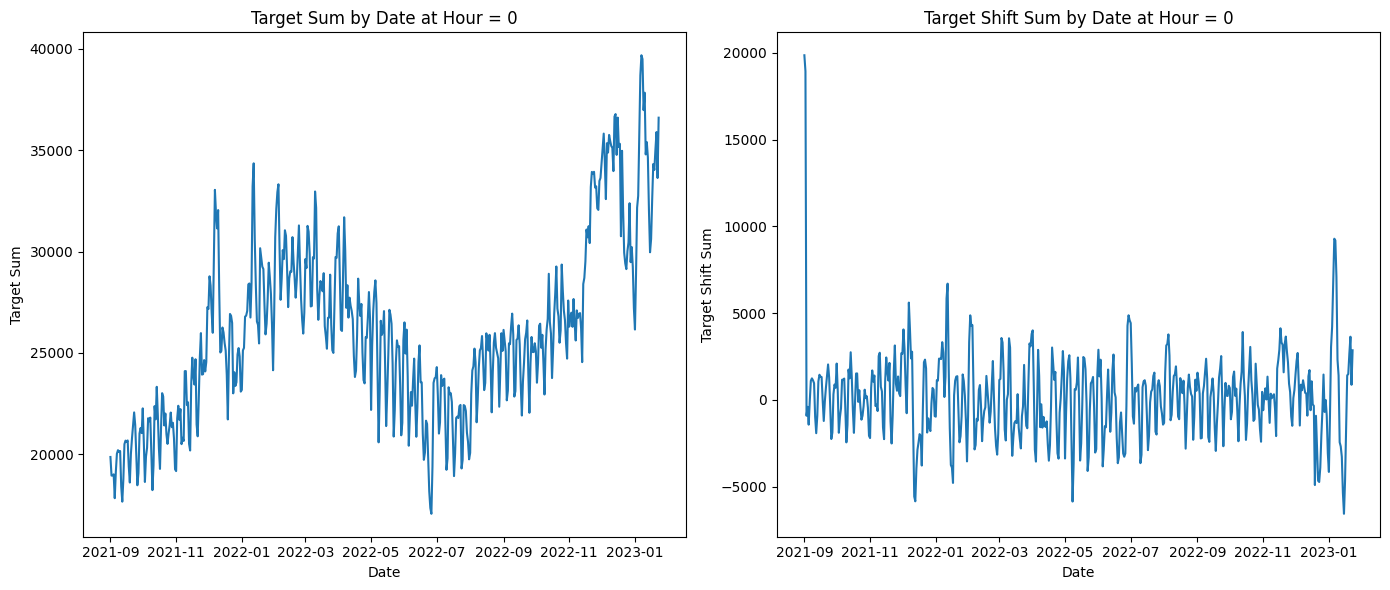

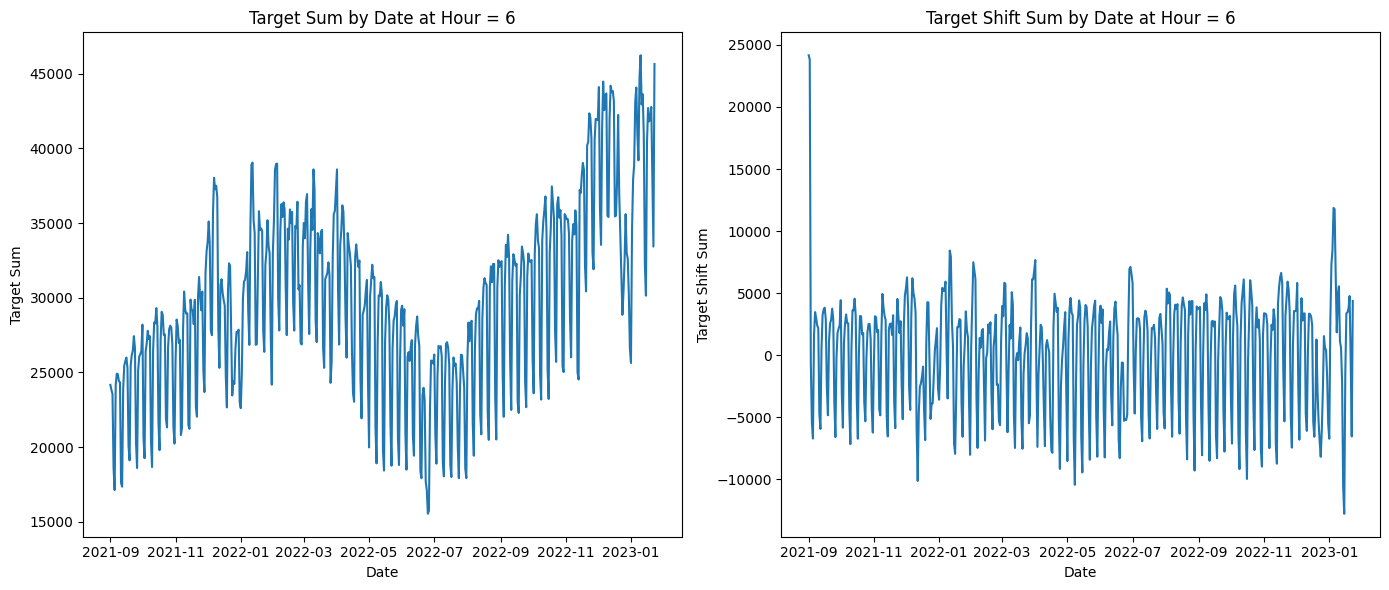

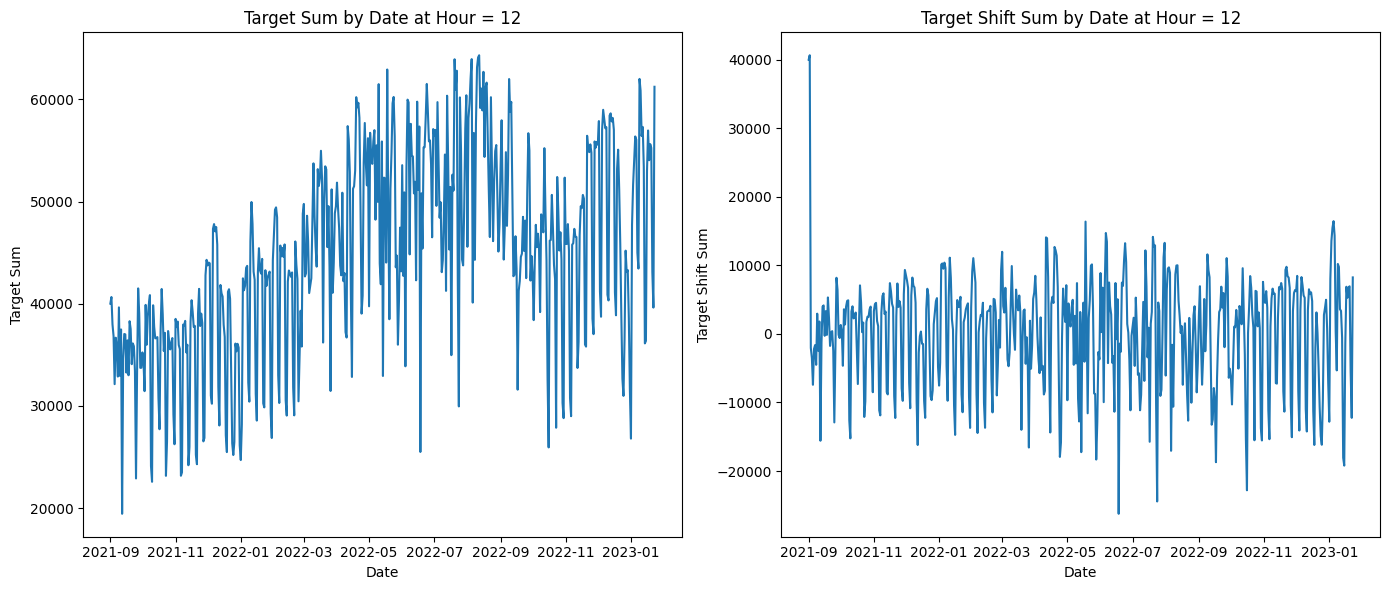

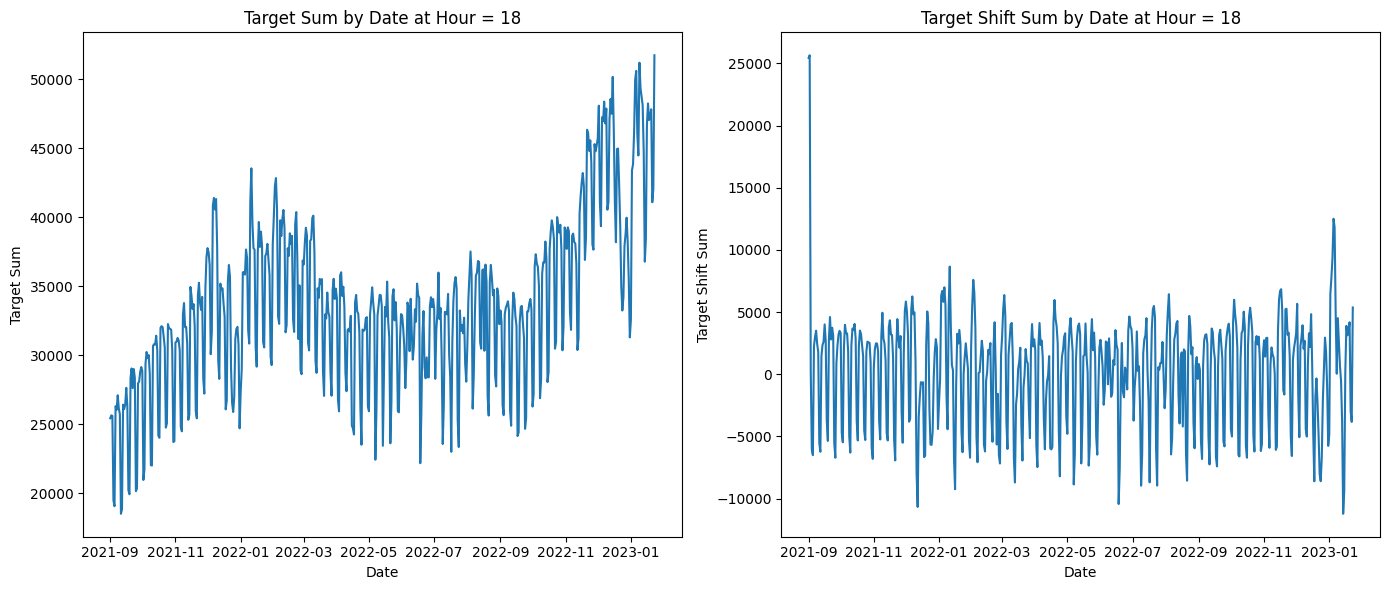

In [35]:
for hour in [0, 6, 12, 18]:
    Target_and_Target_Shift_Plot(hour)

#### target_shift does not show the same incremental trend of target

In [37]:
target = 'target_shift'

In [38]:
%%time
predictors = ['county', 'is_business', 'product_type', 'is_consumption',
              'eic_count', 'installed_capacity',
              'lag_2', 'lag_7', 
              'temperature', 'cloudcover_total', 'direct_solar_radiation', 'total_precipitation', 
              'weekday_sin', 'weekday_cos', 
              'month_sin', 'month_cos',  
              'mean_rolling_1w', 
              'max_rolling_1w',  
              'hour_sin', 'hour_cos',  
              'delta_temperature',  'delta_cloudcover_total', 'delta_direct_solar_radiation', 'delta_total_precipitation' # new 
             ]

preds_lst, performances = [], []

best_params =  { 'objective': 'regression_l1',
                 'reg_sqrt': True,
                 'learning_rate': 0.022802833720521228,
                 'n_estimators': 904,
                 'num_leaves': 330,
                 'max_depth': 152,
                 'subsample': 0.6187956762652326,
                 'subsample_freq': 5,
                 'colsample_bytree': 0.9333501721355958,
                 'reg_lambda': 0.0030748108994051613,
                 'reg_alpha': 8.132931175005272, 
                 'random_state' : 73, 
                 'verbose' : -1}

learner = lgb.LGBMRegressor(**best_params)

for fold in range(1,6):
    temp, valid = TRAIN_CV.filter(pl.col('cv_fold')==fold), VALID.filter(pl.col('cv_fold')==fold)
    
    model = learner.fit(temp.select(predictors).to_numpy(), temp.select(target).to_numpy())
    
    valid = valid.with_columns(pl.Series(name='delta_preds', values=model.predict(valid.select(predictors).to_numpy())))
    
    fold_preds = ((valid['delta_preds'])+(valid['mean_rolling_1w'].fill_null(0))).to_numpy().clip(0)
    
    preds_lst.append(fold_preds)
    
    mae_fold = mae(valid['target'], fold_preds)
    
    performance = round(((best_MAEs[f'Fold {fold}'] - mae_fold)/(best_MAEs[f'Fold {fold}']))*100,2) # positive if score, i.e. mae of the model is lower then the baseline's mae
    print(f'FOLD {fold} Model Performance VS Best Model: {performance}%')
    
    performances.append(performance)
    

print(' ')
print(f'Mean Model Performance VS Best Model: {round(np.array(performances).mean(),2)}%')   

VALID = VALID.with_columns(pl.Series(name='preds', values = np.concatenate(preds_lst)).cast(pl.Float32))

FOLD 1 Model Performance VS Best Model: 24.06%
FOLD 2 Model Performance VS Best Model: 31.23%
FOLD 3 Model Performance VS Best Model: 34.32%
FOLD 4 Model Performance VS Best Model: 37.08%
FOLD 5 Model Performance VS Best Model: 28.77%
 
Mean Model Performance VS Best Model: 31.09%
CPU times: user 35min 34s, sys: 3.72 s, total: 35min 38s
Wall time: 35min 39s


In [39]:
%%time
learner = lgb.LGBMRegressor(**best_params)
model = learner.fit(train.select(predictors).to_numpy(), train.select(target).to_numpy())

test = test.with_columns(pl.Series(name='delta_preds', values=model.predict(test.select(predictors).to_numpy())))

test = test.with_columns(pl.Series(name = 'preds', values = ((test['delta_preds'])+(test['mean_rolling_1w'].fill_null(0))).to_numpy().clip(0)))

test_mae = mae(test['target'], test['preds'])

test_performance = round(((test_best - test_mae)/(test_best))*100,2)
print(f'Mean Performance: {test_performance}%')  

Mean Performance: 36.62%
CPU times: user 12min 44s, sys: 873 ms, total: 12min 45s
Wall time: 12min 47s


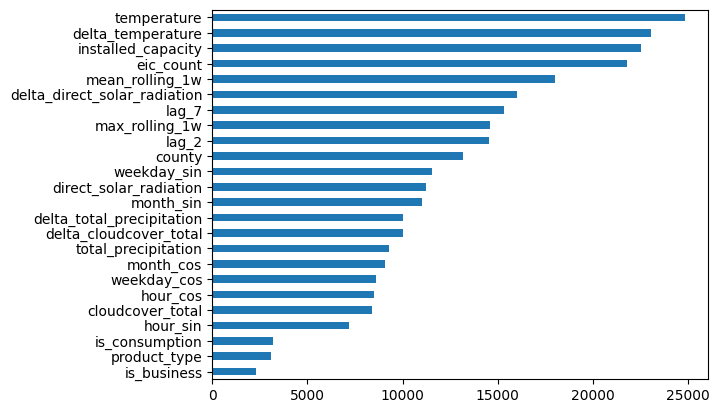

In [40]:
predictors_importances = pd.Series({predictors[i]:model.feature_importances_[i] for i in range(len(predictors))}).sort_values()


predictors_importances.plot(kind='barh');